# <center>Đồ án 3: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Nguyễn Quốc Thắng
- MSSV: 22127385
- Lớp: 22CLC01

# Import

In [281]:
import pandas as pd
import numpy as np

# Import thêm dữ thư viện nếu cần
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.pyplot import box

import seaborn as sns # heatmap

# Đọc dữ liệu

In [282]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa 5 đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu huấn luyện)
    
X_test = test.iloc[:, :-1]      # Dataframe (chứa 5 đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Cài đặt hàm

In [283]:
# Cài đặt các hàm cần thiết ở đây

# Tiền xử lý dữ liệu
def preprocess(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

class OLSLinearRegression:
    # Sử dụng Ordinary Least Squares để tìm nghiệm 
    
    def fit(self, X, y):
        X_pinv = np.linalg.pinv(X) # Sử dụng pseudo-inverse để tránh lỗi ma trận không khả nghịch
        self.w = X_pinv @ y
        return self
    
    def get_params(self):
        return self.w
    
    def predict(self, X):
        return X @ self.w
    
# Xáo trộn dữ liệu
def shuffle_data(X_train, y_train):
    assert X_train.shape[0] == y_train.shape[0]
    # Create a fixed permutation of indices
    fixed_permutation = np.arange(X_train.shape[0])
    np.random.default_rng(42).shuffle(fixed_permutation)  # Using a fixed seed here for the permutation
    return X_train.iloc[fixed_permutation], y_train.iloc[fixed_permutation]

# Chia dữ liệu thành k phần
def k_fold_split(X, y, k):
    fold_size = X.shape[0] // k
    X_folds = []
    y_folds = []
    for i in range(k):
        X_fold = X[i * fold_size:(i + 1) * fold_size]
        y_fold = y[i * fold_size:(i + 1) * fold_size]
        X_folds.append(X_fold)
        y_folds.append(y_fold)
    return X_folds, y_folds

# Huấn luyện mô hình
def train_linear_regression(X, y):
    X = preprocess(X)
    lr = OLSLinearRegression().fit(X, y)
    return lr

def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))
    
# Cross-validation
def cross_validation(X_train, y_train, k):
    X_folds, y_folds = k_fold_split(X_train, y_train, k)
    mae_folds = []
    for i in range(k):
        X_train_cv = np.concatenate([X_folds[j] for j in range(k) if j != i])
        y_train_cv = np.concatenate([y_folds[j] for j in range(k) if j != i])
        X_val_cv = X_folds[i]
        y_val_cv = y_folds[i]
        lr = train_linear_regression(X_train_cv, y_train_cv)
        y_pred = lr.predict(preprocess(X_val_cv))
        mae = MAE(y_val_cv, y_pred)
        mae_folds.append(mae)

    return np.mean(mae_folds)


*Chú thích: Cần có docstrings cho các hàm.*

# Yêu cầu 1: Phân tích khám phá dữ liệu (1 điểm)

### 1. Hiểu rõ dữ liệu <a class="anchor" id="c11"></a>
#### a. Tải và hiển thị dữ liệu

In [284]:
# Tải dữ liệu và 1 DataFrame
train = pd.read_csv('train.csv') 

# Hiển thị thông tin tổng quan về dữ liệu
train.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,77,0,5,2,69.0
1,8,90,1,4,1,84.0
2,9,83,1,6,3,82.0
3,4,52,0,9,5,38.0
4,4,82,1,8,6,68.0


In [285]:
train.tail()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
8995,2,41,1,4,6,13.0
8996,3,74,1,4,1,50.0
8997,7,65,0,4,1,53.0
8998,8,48,0,7,7,40.0
8999,4,59,0,9,7,42.0


#### b. Kiểm tra thông tin dữ liệu

In [286]:
# Thông tin về kiểu dữ liệu của các cột
train.info()

# Thống kê mô tả (bao gồm : count, mean, std, min, max, 25%, 50%, 75%)
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     9000 non-null   int64  
 1   Previous Scores                   9000 non-null   int64  
 2   Extracurricular Activities        9000 non-null   int64  
 3   Sleep Hours                       9000 non-null   int64  
 4   Sample Question Papers Practiced  9000 non-null   int64  
 5   Performance Index                 9000 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 422.0 KB


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,4.976444,69.396111,0.493667,6.535556,4.590889,55.136333
std,2.594647,17.369957,0.499988,1.695533,2.864570,19.187669
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,0.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,0.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,1.000000,8.000000,7.000000,70.000000
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000


### 2. Phân tích đơn biến (Univariate Analysis) <a class="anchor" id="c11"></a>
#### a. Đặc trưng liên tục (use boxplot)

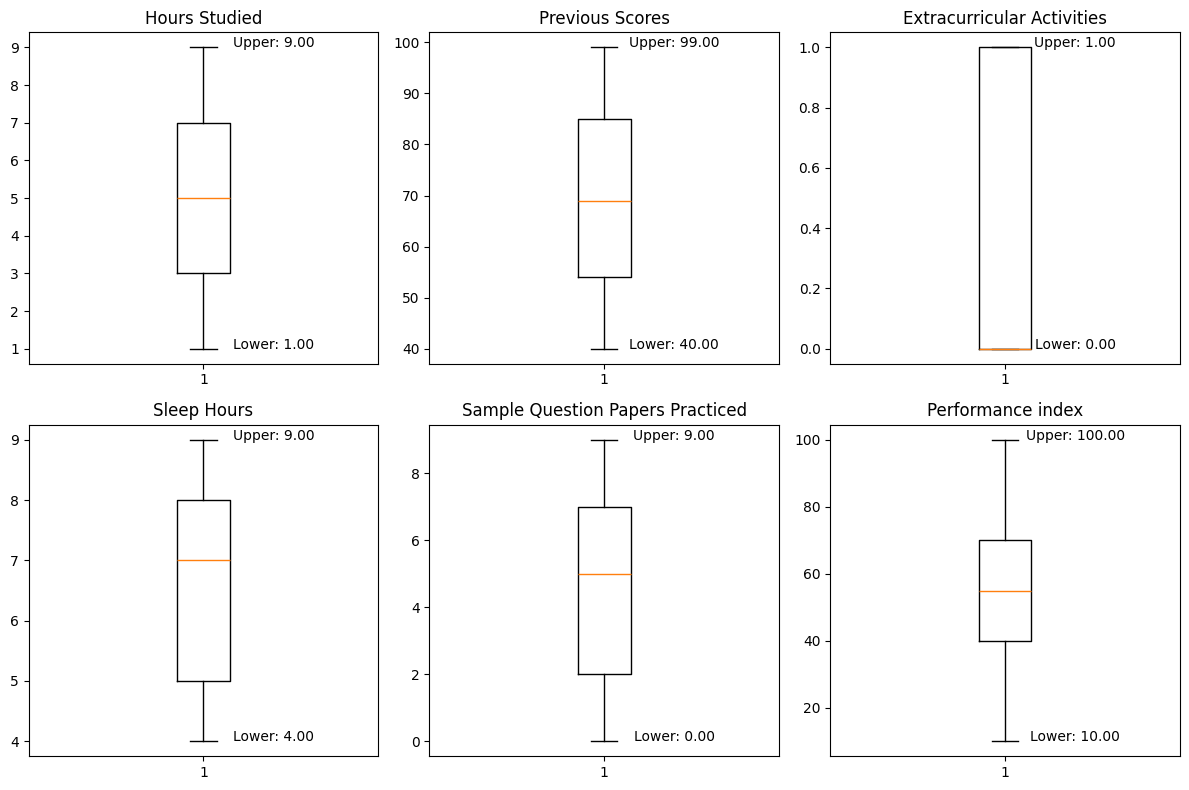

In [287]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Boxplot for Hours Studied
box = axes[0, 0].boxplot(X_train['Hours Studied'])
axes[0, 0].set_title('Hours Studied')
axes[0, 0].text(1.2, box['whiskers'][0].get_ydata()[1], f"Lower: {box['whiskers'][0].get_ydata()[1]:.2f}", ha='center')
axes[0, 0].text(1.2, box['whiskers'][1].get_ydata()[1], f"Upper: {box['whiskers'][1].get_ydata()[1]:.2f}", ha='center')

# Boxplot for Previous Scores
box1 = axes[0, 1].boxplot(X_train['Previous Scores'])
axes[0, 1].set_title('Previous Scores')
axes[0, 1].text(1.2, box1['whiskers'][0].get_ydata()[1], f"Lower: {box1['whiskers'][0].get_ydata()[1]:.2f}", ha='center')
axes[0, 1].text(1.2, box1['whiskers'][1].get_ydata()[1], f"Upper: {box1['whiskers'][1].get_ydata()[1]:.2f}", ha='center')

# Boxplot for Extracurricular Activities
box2 = axes[0, 2].boxplot(X_train['Extracurricular Activities'])
axes[0, 2].set_title('Extracurricular Activities')
axes[0, 2].text(1.2, box2['whiskers'][0].get_ydata()[1], f"Lower: {box2['whiskers'][0].get_ydata()[1]:.2f}", ha='center')
axes[0, 2].text(1.2, box2['whiskers'][1].get_ydata()[1], f"Upper: {box2['whiskers'][1].get_ydata()[1]:.2f}", ha='center')

# Boxplot for Sleep Hours
box3 = axes[1, 0].boxplot(X_train['Sleep Hours'])
axes[1, 0].set_title('Sleep Hours')
axes[1, 0].text(1.2, box3['whiskers'][0].get_ydata()[1], f"Lower: {box3['whiskers'][0].get_ydata()[1]:.2f}", ha='center')
axes[1, 0].text(1.2, box3['whiskers'][1].get_ydata()[1], f"Upper: {box3['whiskers'][1].get_ydata()[1]:.2f}", ha='center')

# Boxplot for Sample Question Papers Practiced
box4 = axes[1, 1].boxplot(X_train['Sample Question Papers Practiced'])
axes[1, 1].set_title('Sample Question Papers Practiced')
axes[1, 1].text(1.2, box4['whiskers'][0].get_ydata()[1], f"Lower: {box4['whiskers'][0].get_ydata()[1]:.2f}", ha='center')
axes[1, 1].text(1.2, box4['whiskers'][1].get_ydata()[1], f"Upper: {box4['whiskers'][1].get_ydata()[1]:.2f}", ha='center')

# Boxplot for Performance index
box5 = axes[1, 2].boxplot(y_train)
axes[1, 2].set_title('Performance index')
axes[1, 2].text(1.2, box5['whiskers'][0].get_ydata()[1], f"Lower: {box5['whiskers'][0].get_ydata()[1]:.2f}", ha='center')
axes[1, 2].text(1.2, box5['whiskers'][1].get_ydata()[1], f"Upper: {box5['whiskers'][1].get_ydata()[1]:.2f}", ha='center')

# Tạo tiêu đề cho toàn bộ plot
fig.tight_layout()

# Hiển thị plot
plt.show()


#### b. Đặc trưng phân loại (Categorial)

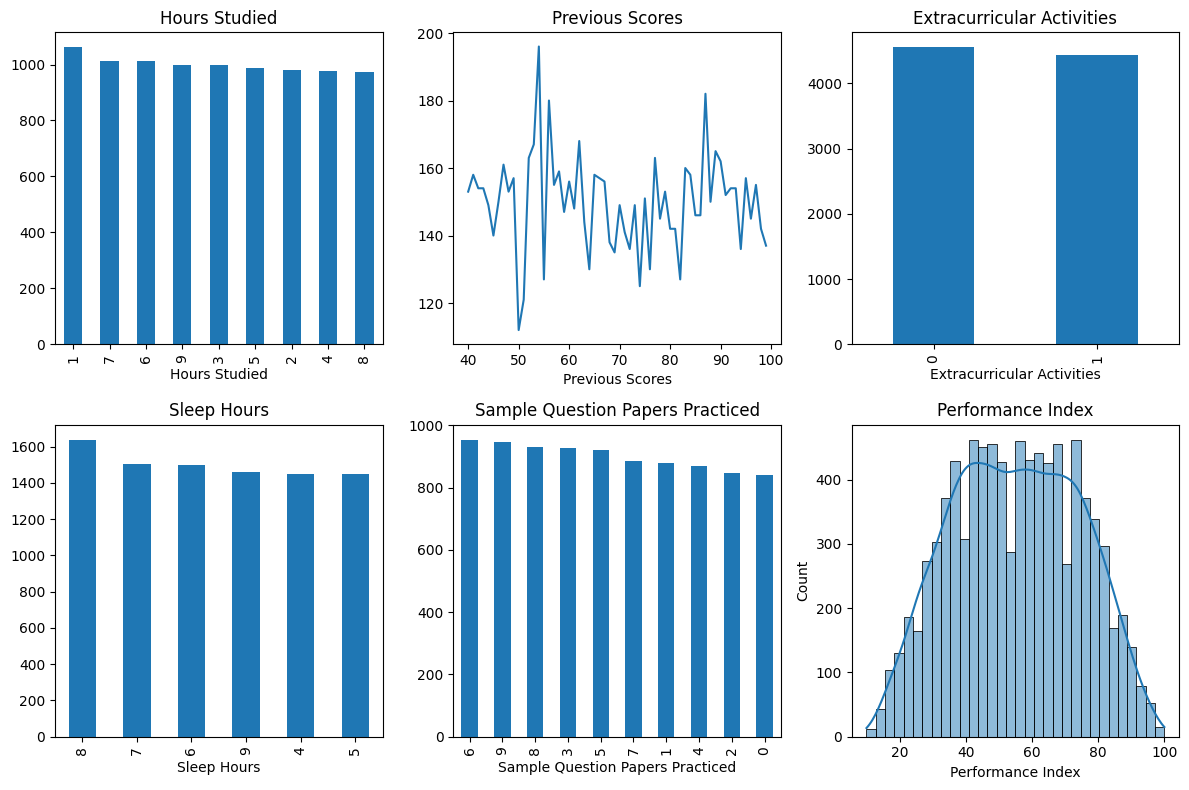

In [288]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Barplot for Hours Studied
barplot = X_train['Hours Studied'].value_counts().plot(kind='bar', title='Hours Studied', ax=axes[0, 0])

# Barplot for Previous Scores
lineplot1 = X_train['Previous Scores'].value_counts().sort_index().plot(kind='line', title='Previous Scores', ax=axes[0, 1])

# Barplot for Extracurricular Activities
barplot2 = X_train['Extracurricular Activities'].value_counts().plot(kind='bar', title='Extracurricular Activities', ax=axes[0, 2])

# Barplot for Sleep Hours
barplot3 = X_train['Sleep Hours'].value_counts().plot(kind='bar', title='Sleep Hours', ax=axes[1, 0])

# Barplot for Sample Question Papers Practiced
barplot4 = X_train['Sample Question Papers Practiced'].value_counts().plot(kind='bar', title='Sample Question Papers Practiced', ax=axes[1, 1])

# Scatter plot for Performance Index
histplot = sns.histplot(y_train, kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Performance Index')

# Tạo tiêu đề cho toàn bộ plot
fig.tight_layout()

# Hiển thị plot
plt.show()

### 3. Phân tích song biến (Bivariate Analysis) <a class="anchor" id="c11"></a>
#### Mối tương quan giữa biến đặc trưng (x1, x2,.., x5) với biến mục tiêu (y)

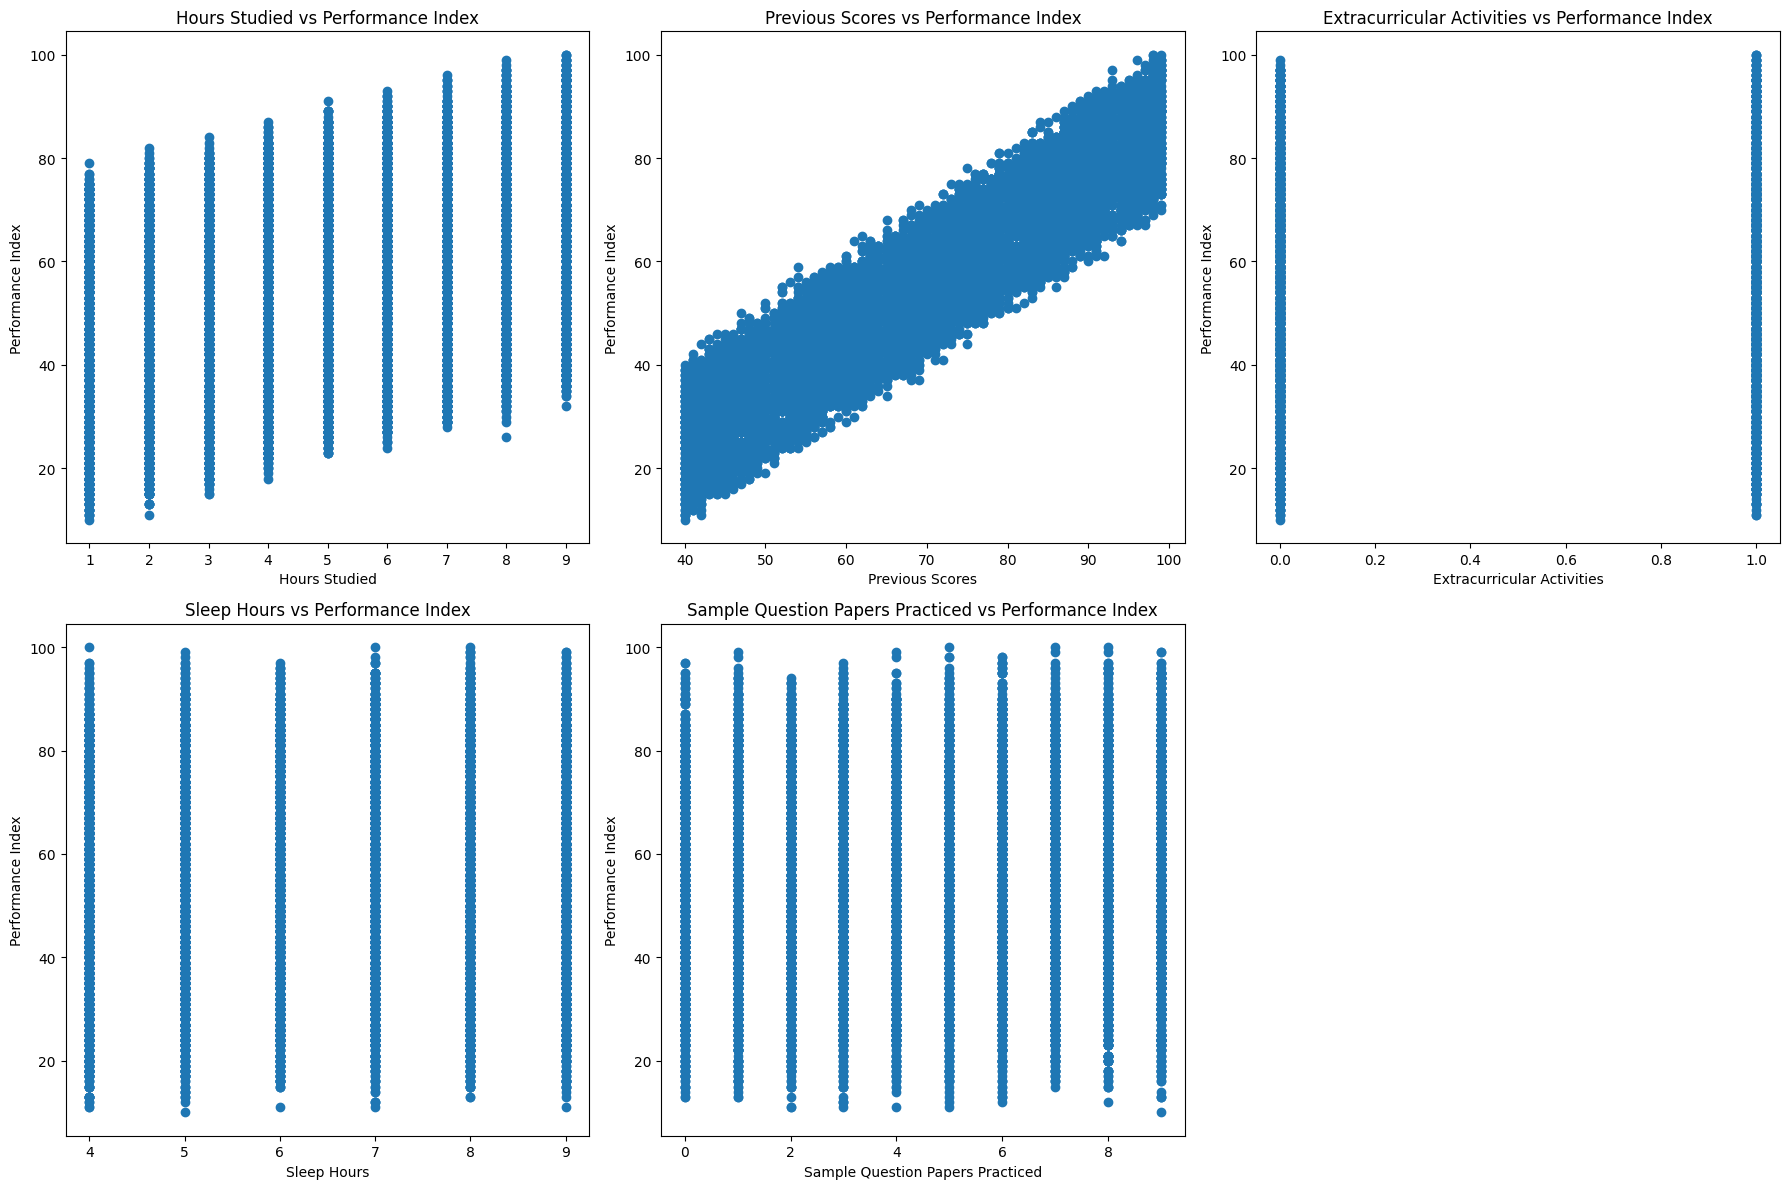

In [289]:
# Phân tích mối quan hệ giữa các đặc trưng và giá trị mục tiêu thông qua biểu đồ
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Scatter plot for Hours Studied
scatter1 = axes[0, 0].scatter(X_train['Hours Studied'], y_train)
axes[0, 0].set_title('Hours Studied vs Performance Index')
axes[0, 0].set_xlabel('Hours Studied')
axes[0, 0].set_ylabel('Performance Index')

# Scatter plot for Previous Scores
scatter2 = axes[0, 1].scatter(X_train['Previous Scores'], y_train)
axes[0, 1].set_title('Previous Scores vs Performance Index')
axes[0, 1].set_xlabel('Previous Scores')
axes[0, 1].set_ylabel('Performance Index')

# Scatter plot for Extracurricular Activities
scatter3 = axes[0, 2].scatter(X_train['Extracurricular Activities'], y_train)
axes[0, 2].set_title('Extracurricular Activities vs Performance Index')
axes[0, 2].set_xlabel('Extracurricular Activities')
axes[0, 2].set_ylabel('Performance Index')

# Scatter plot for Sleep Hours
scatter4 = axes[1, 0].scatter(X_train['Sleep Hours'], y_train)
axes[1, 0].set_title('Sleep Hours vs Performance Index')
axes[1, 0].set_xlabel('Sleep Hours')
axes[1, 0].set_ylabel('Performance Index')

# Scatter plot for Sample Question Papers Practiced
scatter5 = axes[1, 1].scatter(X_train['Sample Question Papers Practiced'], y_train)
axes[1, 1].set_title('Sample Question Papers Practiced vs Performance Index')
axes[1, 1].set_xlabel('Sample Question Papers Practiced')
axes[1, 1].set_ylabel('Performance Index')

# Xóa empty subplot (1,2) không dùng
fig.delaxes(axes[1, 2])

# Điều chỉnh khoảng cách giữa các subplot
fig.tight_layout()

# Hiển thị plot
plt.show()


#### Hệ số tương quan Pearson

$$ r = \frac{\sum (X - \overline{X})(Y - \overline{Y})}{\sqrt{\sum (X - \overline{X})^2 \sum (Y - \overline{Y})^2}} $$

Trong đó:
- r là hệ số tương quan Pearson.
- X và Y là các giá trị của hai biến.

In [290]:
# Hệ số tương quan Pearson để định lượng mức độ tương quan giữa mỗi đặc trưng và biến mục tiêu.
correlation = X_train.corrwith(y_train)
print(correlation)

Hours Studied                       0.369148
Previous Scores                     0.914775
Extracurricular Activities          0.025637
Sleep Hours                         0.043980
Sample Question Papers Practiced    0.041088
dtype: float64


### 4. Phân tích đa biến (Multivariate Analysis) <a class="anchor" id="c11"></a>
Bản đồ nhiệt của ma trận tương quan:
- Tạo một heatmap của ma trận tương quan để xem các mối tương quan giữa tất cả các cặp đặc trưng với nhau. Điều này giúp bạn xác định xem có những đặc trưng nào có mối tương quan mạnh mẽ với nhau hoặc với biến mục tiêu hay không.
- Student Perfromance HeatMap:
    + Màu đỏ đậm: biểu diễn tương quan dương mạnh ( gần 1).
    + Màu xanh đậm: biểu diễn tương quan âm mạnh ( gần -1).
    + Màu trắng hoặc xanh nhạt: biểu diễn không có tương quan hoặc tương quan yếu.

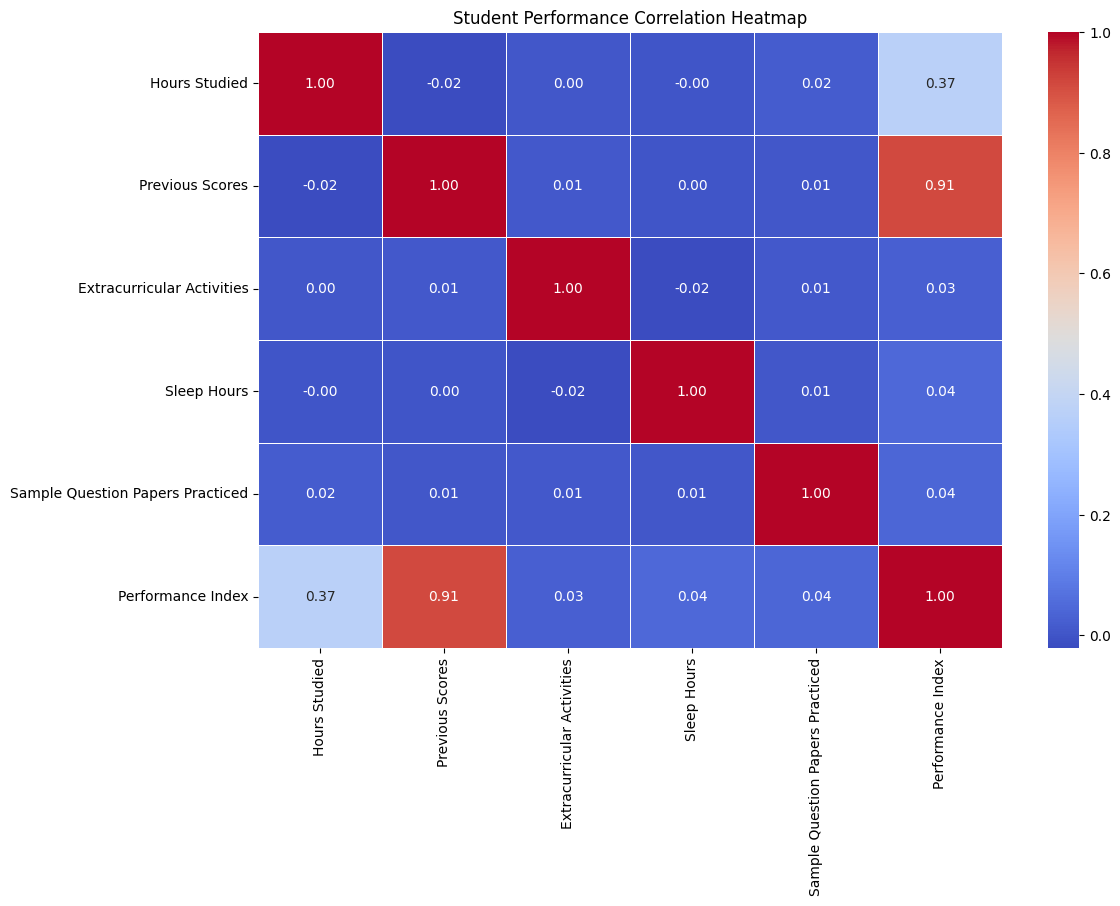

In [291]:
fig, ax = plt.subplots(figsize=(12, 8))
X_Y = pd.concat([X_train, y_train], axis=1) # Combine X_train and y_train
heatmap = sns.heatmap(X_Y.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, ax=ax)
plt.title('Student Performance Correlation Heatmap')
plt.show()

### 5. Kiểm tra giá trị thiếu (Missing values) và ngoại lệ (Outliers) <a class="anchor" id="c11"></a>
#### a. Giá trị thiếu (Missing values)

In [292]:
missing_values = train.isnull().sum()
print(missing_values)

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


#### b. Ngoại lệ (Outliers)

In [293]:
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1
outliers = ((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).sum()
print("-------------------First Quartile-------------------")
print(Q1)
print("-------------------Third Quartile-------------------")
print(Q3)
print("-------------------Total outliers-------------------")
print(outliers)

-------------------First Quartile-------------------
Hours Studied                        3.0
Previous Scores                     54.0
Extracurricular Activities           0.0
Sleep Hours                          5.0
Sample Question Papers Practiced     2.0
Name: 0.25, dtype: float64
-------------------Third Quartile-------------------
Hours Studied                        7.0
Previous Scores                     85.0
Extracurricular Activities           1.0
Sleep Hours                          8.0
Sample Question Papers Practiced     7.0
Name: 0.75, dtype: float64
-------------------Total outliers-------------------
Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
dtype: int64


# Yêu cầu 2a: Xây dựng mô hình sử dụng toàn bộ 5 đặc trưng đề bài cung cấp (2 điểm) 

#### 1. Xây dựng mô hình

Công thức hồi quy:

$$\text{Student Performance} = theta0 + theta1*Hours Studied + theta2 * Previous Scores + theta2 * Extracurricular + theta3 * Sleep Hours + theta4 * Sample Question Papers Practiced $$

In [294]:
# Training model

# Step1. Tiền xử lý dữ liệu
# Tạo các bản copy của dữ liệu huấn luyện và kiểm tra
X_train_2a = X_train.copy()
y_train_2a = y_train.copy()

X_test_2a = X_test.copy()
y_test_2a = y_test.copy()

X_train_2a = preprocess(X_train_2a)
X_test_2a = preprocess(X_test_2a)

# Step2. Huấn luyện mô hình
lr = OLSLinearRegression().fit(X_train_2a, y_train_2a)
w = lr.get_params()
w = np.round(w, 3)
print("Weights: ", w)

# Step3. Dự đoán giá trị
y_pred_2a = lr.predict(X_test_2a)
y_pred_2a = np.round(y_pred_2a, 3)

Weights:  [-33.969   2.852   1.018   0.604   0.474   0.192]


Công thức hồi quy:

$$\text{Student Performance} = -33.969 + 2.852*Hours Studied + 1.018 * Previous Scores + 0.604 * Extracurricular + 0.474 * Sleep Hours + 0.192 * Sample Question Papers Practiced $$

#### 2. Giá trị dự đoán

In [295]:
X_Y_test_2a = np.hstack([X_test_2a, y_pred_2a.reshape(-1, 1)]) # combine X_test and y_pred 
X_Y_test_2a = pd.DataFrame(X_Y_test_2a) # chuyển sang DataFrame 
X_Y_test_2a.drop(X_Y_test_2a.columns[0], axis=1, inplace=True) # bỏ first column 
X_Y_test_2a.columns = ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced','Performance Index (Prediction)'] # set name for columns 
X_Y_test_2a.head() # hiển thị 5 dòng đầu của dữ liệu

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index (Prediction)
0,7.0,74.0,0.0,8.0,1.0,65.298
1,6.0,89.0,1.0,8.0,8.0,79.665
2,3.0,79.0,0.0,8.0,1.0,58.979
3,7.0,62.0,0.0,8.0,8.0,54.430
4,5.0,51.0,0.0,7.0,7.0,36.864


#### 3. Trực quan hóa Giá trị dự đoán và Giá trị thực tế (tập Test)

##### a. Trên toàn bộ dữ liệu

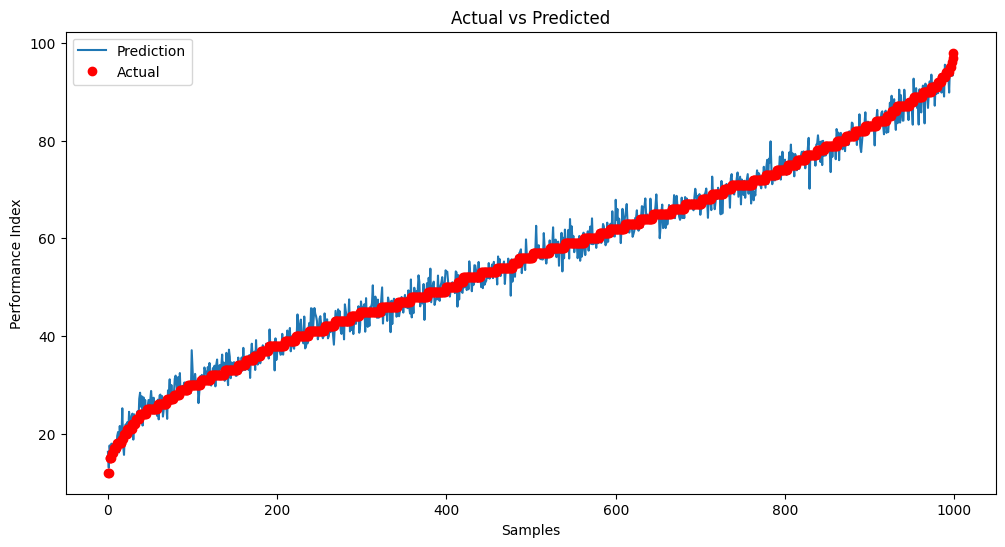

In [296]:
# Sắp xếp các giá trị từ nhỏ nhất đến lớn nhất
sorted_indices = np.argsort(y_test_2a)
sorted_y_test = y_test_2a.values[sorted_indices]
sorted_y_pred = y_pred_2a[sorted_indices]

# Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán
plt.figure(figsize=(12, 6))

# Sử dụng đường để hiển thị giá trị dự đoán
plt.plot(sorted_y_pred, label='Prediction')

# Sử dụng điểm để hiển thị giá trị thực tế
plt.plot(sorted_y_test, 'ro', label='Actual')

plt.xlabel('Samples')
plt.ylabel('Performance Index')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()


##### b. Trên 10 dòng dữ liệu đầu

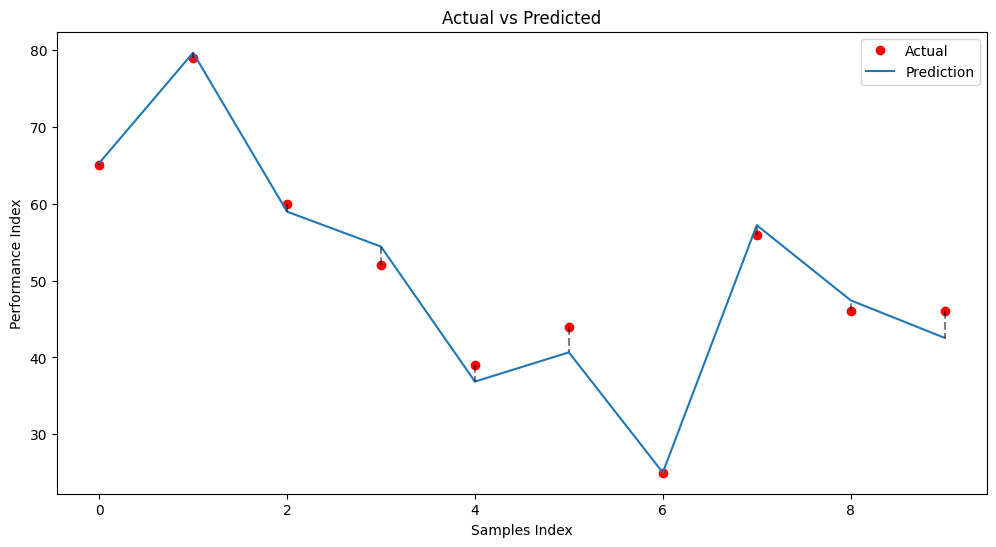

In [297]:
# Draw line plot to compare the actual and predicted values

# Take first 10 samples to draw
plt.figure(figsize=(12, 6))
plt.plot(y_test_2a.values[:10],'ro',label='Actual')

# using line to show the predicted values
plt.plot(y_pred_2a[:10], label='Prediction')

# Draw a line to connect the actual and predicted values
for i in range(10):
    plt.plot([i, i], [y_test_2a.values[i], y_pred_2a[i]], 'k--', alpha=0.5)

plt.xlabel('Samples Index')
plt.ylabel('Performance Index')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

#### 4. Tính MAE trên tập Test

In [298]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

mae = MAE(y_test_2a, y_pred_2a)
print("MAE on test set: ", mae)

#[-33.969   2.852   1.018   0.604   0.474   0.192]

MAE on test set:  1.5956569999999999


# Yêu cầu 2b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng, tìm mô hình cho kết quả tốt nhất (2 điểm)

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

#### 1. Xây dựng mô hình với một đặc trưng kết hợp với cross-validation

In [299]:
# Step1. Tiền xử lý dữ liệu
# 1.1. Tách từng đặc trưng ra để huấn luyện và kiểm tra
X_train_2b = X_train.copy()
y_train_2b = y_train.copy()
X_test_2b = X_test.copy()
y_test_2b = y_test.copy()

# 1.2. Xáo trộn và chia dữ liệu thành k phần (cross-validation)
# Thực hiện cross-validation
k_values = [5, 10, 15]
mae_hours = []
mae_previous = []
mae_extra = []
mae_sleep = []
mae_sample = []

# shuffle data
X_train_2b, y_train_2b = shuffle_data(X_train_2b, y_train_2b)

for k in k_values:
    # Tách X thành từng đặc trưng để huấn luyện và kiểm tra
    X_train_2b_hours = X_train_2b['Hours Studied'].values.reshape(-1, 1)
    X_train_2b_previous = X_train_2b['Previous Scores'].values.reshape(-1, 1)
    X_train_2b_extra = X_train_2b['Extracurricular Activities'].values.reshape(-1, 1)
    X_train_2b_sleep = X_train_2b['Sleep Hours'].values.reshape(-1, 1)
    X_train_2b_sample = X_train_2b['Sample Question Papers Practiced'].values.reshape(-1, 1)

    # Cross-validation với từng đặc trưng với k
    mae_hours.append(cross_validation(X_train_2b_hours, y_train_2b, k).round(5))
    mae_previous.append(cross_validation(X_train_2b_previous, y_train_2b, k).round(5))
    mae_extra.append(cross_validation(X_train_2b_extra, y_train_2b, k).round(5))
    mae_sleep.append(cross_validation(X_train_2b_sleep, y_train_2b, k).round(5))
    mae_sample.append(cross_validation(X_train_2b_sample, y_train_2b, k).round(5))

# In kết quả
def print_mae_results(mae_hours, mae_previous, mae_extra, mae_sleep, mae_sample, k_values):
    for i, k in enumerate(k_values):
        print(f"__________________MAE with cross-validation (k = {k})__________________\n")
        print(f"Hours Studied: {mae_hours[i]}")
        print(f"Previous Scores: {mae_previous[i]}")
        print(f"Extracurricular Activities: {mae_extra[i]}")
        print(f"Sleep Hours: {mae_sleep[i]}")
        print(f"Sample Question Papers Practiced: {mae_sample[i]}")
        print("\n")

#### 2. Tính MAE cho từng đặc trưng (k = 5,10,15)

In [300]:
print_mae_results(mae_hours, mae_previous, mae_extra, mae_sleep, mae_sample, k_values)

__________________MAE with cross-validation (k = 5)__________________

Hours Studied: 15.45611
Previous Scores: 6.61867
Extracurricular Activities: 16.20415
Sleep Hours: 16.19334
Sample Question Papers Practiced: 16.18969


__________________MAE with cross-validation (k = 10)__________________

Hours Studied: 15.45387
Previous Scores: 6.6185
Extracurricular Activities: 16.19994
Sleep Hours: 16.19173
Sample Question Papers Practiced: 16.18775


__________________MAE with cross-validation (k = 15)__________________

Hours Studied: 15.45302
Previous Scores: 6.61836
Extracurricular Activities: 16.19843
Sleep Hours: 16.18951
Sample Question Papers Practiced: 16.18806




#### 3. Huấn luyện lại mô hình với đặc trưng tốt nhất trên toàn tập
##### Đặc trưng lựa chọn: Previous Scores

##### a. Xây dựng mô hình

In [301]:
# Huấn luyện lại mô hình best_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện

# Từ kết quả trên. Ta chọn đặc trưng tốt nhất là 'Previous Scores'
X_train_2b_best = X_train_2b['Previous Scores'].values.reshape(-1, 1)
X_test_2b_best = X_test_2b['Previous Scores'].values.reshape(-1, 1)
y_train_2b_best = y_train_2b

# Step1. Preprocess data
X_train_2b_best = preprocess(X_train_2b_best)
X_test_2b_best = preprocess(X_test_2b_best)

# Step2. Training model
lr = OLSLinearRegression().fit(X_train_2b_best, y_train_2b_best)
w = lr.get_params()
w = np.round(w, 3)
print("Weights: ", w)

# Step3. Predict
y_pred_2b_best = lr.predict(X_test_2b_best)
y_pred_2b_best = np.round(y_pred_2b_best, 3)

Weights:  [-14.989   1.011]


Công thức hồi quy:

$$\text{Student Performance} = -14.989 + 1.011 * Previous Scores $$

##### b. Giá trị dự đoán

In [302]:
# show the predictions with best feature
X_Y_test_2b_best = np.hstack([X_test_2b_best, y_pred_2b_best.reshape(-1, 1)]) # combine X_test and y_pred
X_Y_test_2b_best = pd.DataFrame(X_Y_test_2b_best) # convert to DataFrame 
X_Y_test_2b_best.drop(X_Y_test_2b_best.columns[0], axis=1, inplace=True) # drop the first column
X_Y_test_2b_best.columns = ['Previous Scores','Performance Index (Prediction)'] # set name for columns
X_Y_test_2b_best.head() # show the first 5 predictions

,Previous Scores,Performance Index (Prediction)
0,74.0,59.789
1,89.0,74.946
2,79.0,64.841
3,62.0,47.663
4,51.0,36.547


##### c. Trực quan hóa giá trị dự đoán và giá trị thực tế 
* Trên toàn bộ dữ liệu

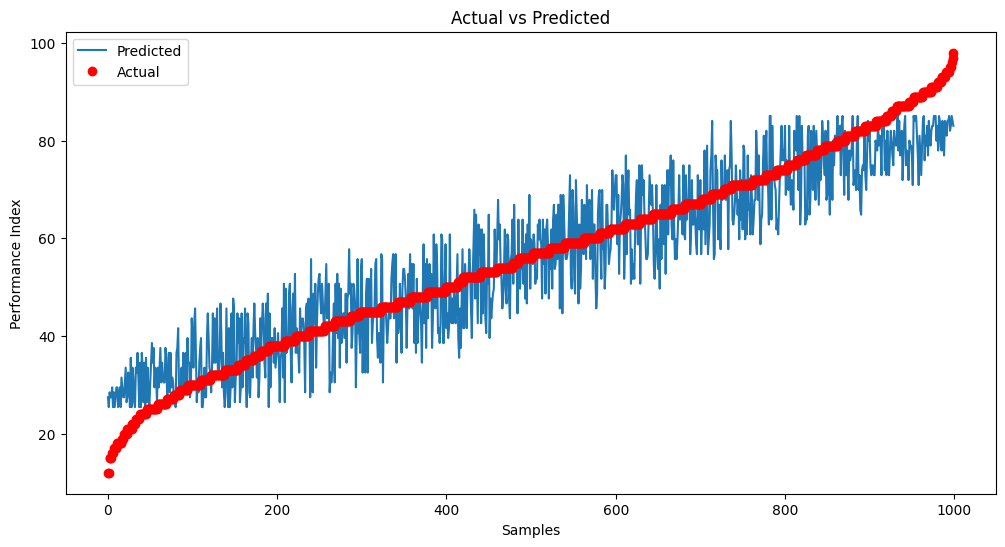

In [303]:
# Draw line plot to compare the actual and predicted values

# Sắp xếp các giá trị từ nhỏ nhất đến lớn nhất
sorted_indices = np.argsort(y_test_2b.values)
sorted_y_test = y_test_2b.values[sorted_indices]
sorted_y_pred = y_pred_2b_best[sorted_indices]

# Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán
plt.figure(figsize=(12, 6))

# Sử dụng điểm để hiển thị giá trị dự đoán
plt.plot(sorted_y_pred, label='Predicted')

# Sử dụng đường thẳng để hiển thị giá trị thực tế
plt.plot(sorted_y_test, 'ro',label='Actual')

plt.xlabel('Samples')
plt.ylabel('Performance Index')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

* Trên 10 dòng dữ liệu đầu tiên

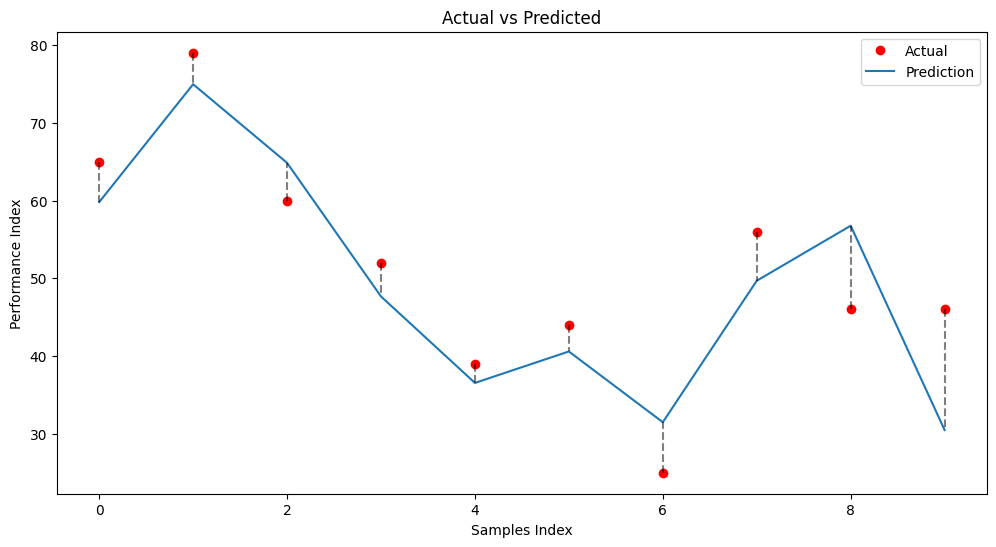

In [304]:

# Take first 10 samples to draw
plt.figure(figsize=(12, 6))
plt.plot(y_test_2b.values[:10],'ro',label='Actual')

# using line to show the predicted values
plt.plot(y_pred_2b_best[:10], label='Prediction')

# Draw a line to connect the actual and predicted values
for i in range(10):
    plt.plot([i, i], [y_test_2b.values[i], y_pred_2b_best[i]], 'k--', alpha=0.5)

plt.xlabel('Samples Index')
plt.ylabel('Performance Index')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

##### d. Tính MAE

In [305]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_feature_model
mae = MAE(y_test_2b, y_pred_2b_best)
print("MAE with best feature (test_set): ", mae.round(3))

MAE with best feature (test_set):  6.544


# Yêu cầu 2c: Sinh viên tự xây dựng/thiết kế mô hình, tìm mô hình cho kết quả tốt nhất (2 điểm)

## Xây dựng/Thiết kế mô hình

In [306]:
# Implement cross-validation with k-fold 
# return the predicted values for each fold
def cross_validation_v2(X_train, y_train, k):
    X_folds, y_folds = k_fold_split(X_train, y_train, k)
    for i in range(k):
        X_train_cv = np.concatenate([X_folds[j] for j in range(k) if j != i])
        y_train_cv = np.concatenate([y_folds[j] for j in range(k) if j != i])
        lr = train_linear_regression(X_train_cv, y_train_cv)

    return lr

# Predict the values for the test set
def predict_v2(X_test, lr):
    return lr.predict(X_test)

def get_params_v2(lr):
    return lr.get_params()

## Tìm mô hình cho kết quả tốt nhất

Lưu ý: Khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

#### 1. Linear Regression Verson 1

* Công thức hồi quy:

$$\text{Student Performance} = Theta0 + Theta1*Hours Studied + Theta2 * Previous Scores $$

In [307]:
# Phần code cho yêu cầu 2c
# Tìm ra mô hình tốt nhất (trong m mô hình mà sinh viên tự thiết kế)
# In ra các kết quả cross-validation như yêu cầu

# Step1. Tiền xử lý dữ liệu
# Tạo bản sao của dữ liệu huấn luyện và kiểm tra
X_train_2c_v1 = X_train.copy()
y_train_2c_v1 = y_train.copy()

X_test_2c_v1 = X_test.copy()
y_test_2c_v1 = y_test.copy()

# Chỉ lấy 2 đặc trưng tốt nhất: 'Previous Scores' và 'Hours Studied'
X_train_2c_v1 = X_train_2c_v1[['Previous Scores', 'Hours Studied']]
X_test_2c_v1 = X_test_2c_v1[['Previous Scores', 'Hours Studied']]

# Step2. Huấn luyện mô hình
k = 5
cross_val_results = []
lr = cross_validation_v2(X_train_2c_v1.values, y_train_2c_v1.values, k)
w = get_params_v2(lr)
print("Weights: ", w)

# Step3. Dự đoán giá trị
X_test_2c_v1 = preprocess(X_test_2c_v1.values)
y_pred_2c_v1 = predict_v2(X_test_2c_v1, lr)
y_pred_2c_v1 = np.round(y_pred_2c_v1, 3)


# Đánh giá mô hình
mae = MAE(y_test_2c_v1, y_pred_2c_v1)
print("MAE with 2 best features (test_set): ", mae)

Weights:  [-29.66729353   1.01773677   2.84945817]
MAE with 2 best features (test_set):  1.8400519999999998


Công thức hồi quy:

$$\text{Student Performance} = -29.66729353 + 1.01773677 * Previous Scores + 2.84945817 * Hours Studied $$

#### c. Trực quan hóa

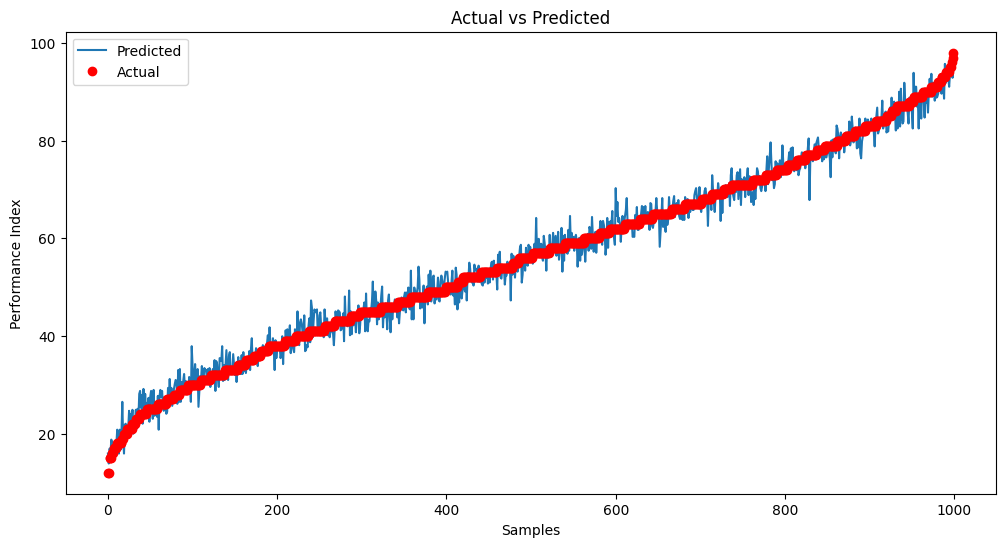

In [308]:
# Sắp xếp các giá trị từ nhỏ nhất đến lớn nhất
sorted_indices = np.argsort(y_test_2c_v1)
sorted_y_test = y_test_2c_v1.values[sorted_indices]
sorted_y_pred = y_pred_2c_v1[sorted_indices]

# Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán
plt.figure(figsize=(12, 6))

# Sử dụng điểm để hiển thị giá trị dự đoán
plt.plot(sorted_y_pred, label='Predicted')

# Sử dụng đường thẳng để hiển thị giá trị thực tế
plt.plot(sorted_y_test, 'ro',label='Actual')

plt.xlabel('Samples')
plt.ylabel('Performance Index')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

* Trên 10 dòng dữ liệu đầu tiên

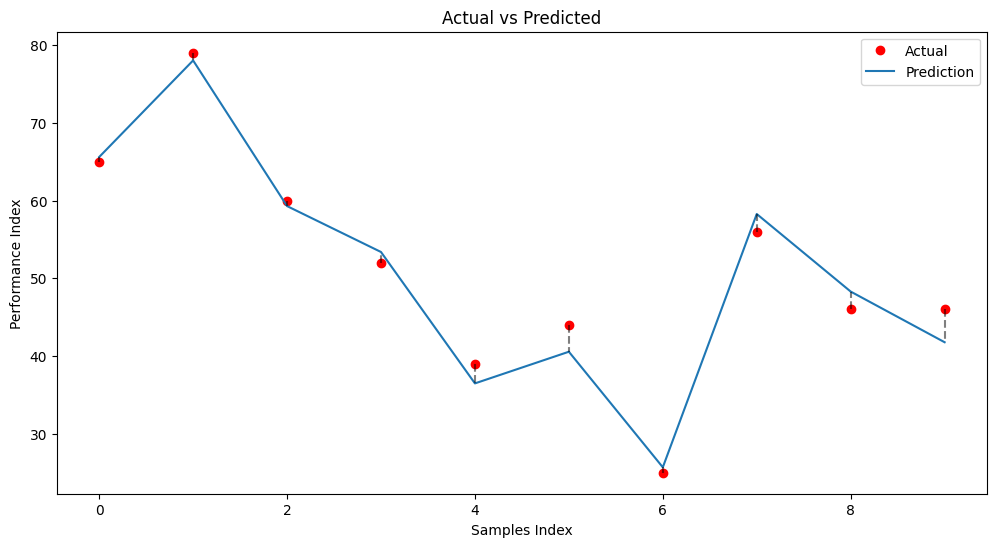

In [309]:
# Take first 10 samples to draw
plt.figure(figsize=(12, 6))
plt.plot(y_test_2c_v1.values[:10],'ro',label='Actual')

# using line to show the predicted values
plt.plot(y_pred_2c_v1[:10], label='Prediction')

# Draw a line to connect the actual and predicted values
for i in range(10):
    plt.plot([i, i], [y_test_2c_v1.values[i], y_pred_2c_v1[i]], 'k--', alpha=0.5)

plt.xlabel('Samples Index')
plt.ylabel('Performance Index')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

#### 2. Linear Regression Version 2

* Công thức hồi quy:

$$\text{Student Performance} = Theta0 + Theta1*Hours Studied + Theta2 * Previous Scores + Theta3 * Extracurricular + Theta4 * Sleep Hours + Theta5 * Sample Question Papers Practiced + Theta6 * (Hours Studied * Previous Scores) $$

##### a. Xây dựng mô hình


In [310]:
# Thêm các đặc trưng mới (Studied Hours * Previous Scores) vào dữ liệu
# Tạo bản sao của dữ liệu huấn luyện và kiểm tra
X_train_2c_v2 = X_train.copy()
y_train_2c_v2 = y_train.copy()

X_test_2c_v2 = X_test.copy()
y_test_2c_v2 = y_test.copy()

# Thêm đặc trưng mới
X_train_2c_v2['Hours Studied * Previous Scores'] = X_train_2c_v2['Hours Studied'] * X_train_2c_v2['Previous Scores']
X_test_2c_v2['Hours Studied * Previous Scores'] = X_test_2c_v2['Hours Studied'] * X_test_2c_v2['Previous Scores']

# Step2. Huấn luyện mô hình
k = 5
cross_val_results = []
lr = cross_validation_v2(X_train_2c_v2, y_train_2c_v2, k)
w = get_params_v2(lr).round(3)
print("Weights: ", w)

# Step3. Dự đoán giá trị
X_test_2c_v2 = preprocess(X_test_2c_v2)
y_pred_2c_v2 = predict_v2(X_test_2c_v2, lr)
y_pred_2c_v2 = np.round(y_pred_2c_v2, 3)

# Đánh giá mô hình
mae = MAE(y_test_2c_v2, y_pred_2c_v2)
print("MAE (test_set): ", mae)


Weights:  [-34.132   2.879   1.02    0.602   0.481   0.193  -0.   ]
MAE (test_set):  1.594931


* Công thức hồi quy:

$$\text{Student Performance} = -34.132 + 2.879 * Hours Studied + 1.02 * Previous Scores + 0.602 * Extracurricular + 0.481 * Sleep Hours + 0.193 * Sample Question Papers Practiced + 0.0002 * (Hours Studied * Previous Scores) $$

#### b.  Giá trị dự đoán

In [311]:
# show the predictions with best feature
X_Y_test_2c_v2 = np.hstack([X_test_2c_v2, y_pred_2c_v2.reshape(-1, 1)]) # combine X_test and y_pred
X_Y_test_2c_v2 = pd.DataFrame(X_Y_test_2c_v2) # convert to DataFrame
X_Y_test_2c_v2.drop(X_Y_test_2c_v2.columns[0], axis=1, inplace=True) # drop the first column
X_Y_test_2c_v2.columns = ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced','Studied Hours * Sample Practiced','Performance Index (Prediction)']
X_Y_test_2c_v2.head() # show the first 5 predictions

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Studied Hours * Sample Practiced,Performance Index (Prediction)
0,7.0,74.0,0.0,8.0,1.0,518.0,65.301
1,6.0,89.0,1.0,8.0,8.0,534.0,79.664
2,3.0,79.0,0.0,8.0,1.0,237.0,59.003
3,7.0,62.0,0.0,8.0,8.0,434.0,54.452
4,5.0,51.0,0.0,7.0,7.0,255.0,36.879


##### c. Trực quan hóa
* Trên toàn tập dữ liệu

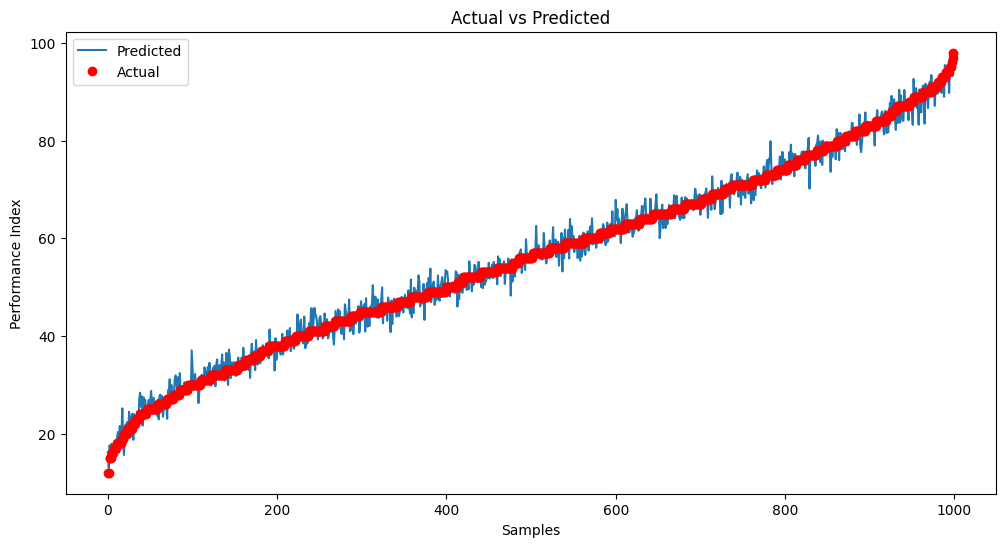

In [312]:
# Sắp xếp các giá trị từ nhỏ nhất đến lớn nhất
sorted_indices = np.argsort(y_test_2c_v2)
sorted_y_test = y_test_2c_v2.values[sorted_indices]
sorted_y_pred = y_pred_2c_v2[sorted_indices]

# Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán
plt.figure(figsize=(12, 6))

# Sử dụng điểm để hiển thị giá trị dự đoán
plt.plot(sorted_y_pred, label='Predicted')

# Sử dụng đường thẳng để hiển thị giá trị thực tế
plt.plot(sorted_y_test, 'ro',label='Actual')

plt.xlabel('Samples')
plt.ylabel('Performance Index')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

* Trên 10 dòng dữ liệu đầu tiên

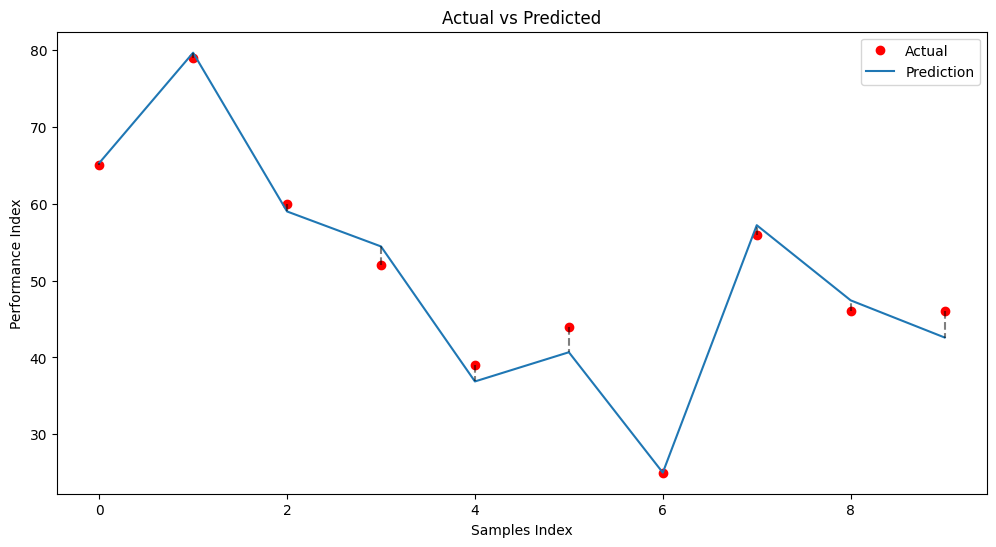

In [313]:
# Take first 10 samples to draw
plt.figure(figsize=(12, 6))
plt.plot(y_test_2c_v2.values[:10],'ro',label='Actual')

# using line to show the predicted values
plt.plot(y_pred_2c_v2[:10], label='Prediction')

# Draw a line to connect the actual and predicted values
for i in range(10):
    plt.plot([i, i], [y_test_2c_v2.values[i], y_pred_2c_v2[i]], 'k--', alpha=0.5)

plt.xlabel('Samples Index')
plt.ylabel('Performance Index')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

#### 3. Linear Regression Version 3

Công thức hồi quy:

$$\text{Student Performance} = Theta0 + Theta1*Hours Studied + Theta2 * Previous Scores + Theta3 * Extracurricular
 + Theta4 * Sleep Hours + Theta5 * Sample Question Papers Practiced
+ Theta6 * (Hours Studied * Previous Scores) + Theta7 * (Previous Scores * Previous Scores) $$

##### a. Xây dựng mô hình

In [314]:
# Tạo bản sao của dữ liệu huấn luyện và kiểm tra
X_train_2c_v3 = X_train.copy()
y_train_2c_v3 = y_train.copy()

X_test_2c_v3 = X_test.copy()
y_test_2c_v3 = y_test.copy()

# Thêm đặc trưng mới
X_train_2c_v3['Hours Studied * Previous Scores'] = X_train_2c_v3['Hours Studied'] * X_train_2c_v3['Previous Scores']
X_test_2c_v3['Hours Studied * Previous Scores'] = X_test_2c_v3['Hours Studied'] * X_test_2c_v3['Previous Scores']

X_test_2c_v3['Previous scores * Previous Scores'] = X_test_2c_v3['Previous Scores'] * X_test_2c_v3['Previous Scores']
X_train_2c_v3['Previous scores * Previous Scores'] = X_train_2c_v3['Previous Scores'] * X_train_2c_v3['Previous Scores']

# Step2. Huấn luyện mô hình
k = 5
cross_val_results = []
lr = cross_validation_v2(X_train_2c_v3, y_train_2c_v3, k)
w = get_params_v2(lr).round(3)
print("Weights: ", w)

# Step3. Dự đoán giá trị
X_test_2c_v3 = preprocess(X_test_2c_v3)
y_pred_2c_v3 = predict_v2(X_test_2c_v3, lr)
y_pred_2c_v3 = np.round(y_pred_2c_v3, 3)

# Đánh giá mô hình
mae = MAE(y_test_2c_v3, y_pred_2c_v3)
print("MAE (test_set): ", mae)


Weights:  [-34.391   2.879   1.028   0.602   0.481   0.193  -0.     -0.   ]
MAE (test_set):  1.5947060000000002


*Công thức hồi quy:

$$\text{Student Performance} = -34.391 + 2.879*Hours Studied + 1.028 * Previous Scores + 0.602 * Extracurricular
 + 0.481 * Sleep Hours + 0.193 * Sample Question Papers Practiced
+ 0.000002 * (Hours Studied * Previous Scores) + 0.00002 * (Previous Scores * Previous Scores) $$

##### b. Giá trị dự đoán

In [315]:
# show the predictions with best feature
X_Y_test_2c_v3 = np.hstack([X_test_2c_v3, y_pred_2c_v3.reshape(-1, 1)]) # combine X_test and y_pred
X_Y_test_2c_v3 = pd.DataFrame(X_Y_test_2c_v3) # convert to DataFrame
X_Y_test_2c_v3.drop(X_Y_test_2c_v3.columns[0], axis=1, inplace=True) # drop the first column
X_Y_test_2c_v3.columns = ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced','Studied Hours * Sample Practiced','Sample Practiced * Sample Practiced','Performance Index (Prediction)']
X_Y_test_2c_v3.head() # show the first 5 predictions

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Studied Hours * Sample Practiced,Sample Practiced * Sample Practiced,Performance Index (Prediction)
0,7.0,74.0,0.0,8.0,1.0,518.0,5476.0,65.317
1,6.0,89.0,1.0,8.0,8.0,534.0,7921.0,79.660
2,3.0,79.0,0.0,8.0,1.0,237.0,6241.0,59.015
3,7.0,62.0,0.0,8.0,8.0,434.0,3844.0,54.466
4,5.0,51.0,0.0,7.0,7.0,255.0,2601.0,36.877


##### c. Trực quan hóa

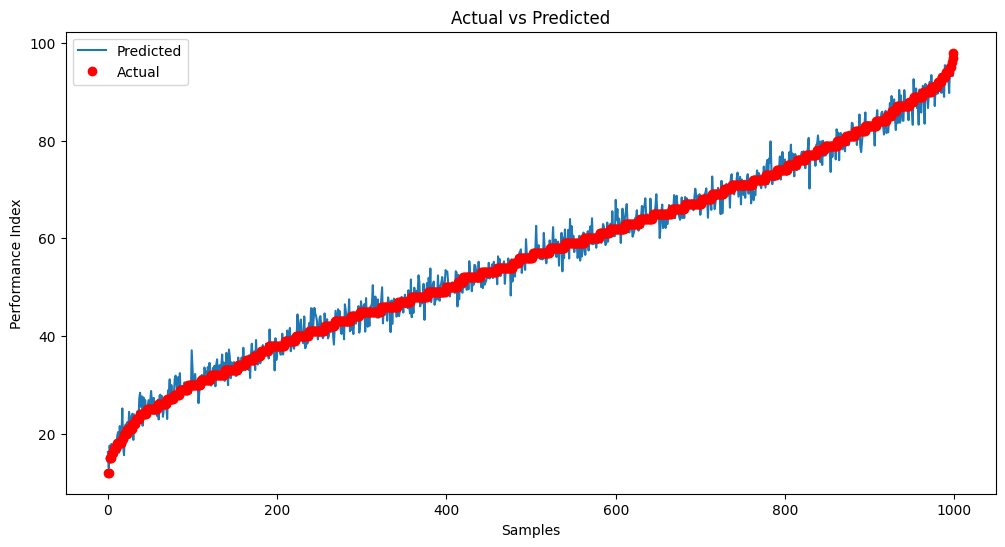

In [316]:
# Sắp xếp các giá trị từ nhỏ nhất đến lớn nhất
sorted_indices = np.argsort(y_test_2c_v3)
sorted_y_test = y_test_2c_v3.values[sorted_indices]
sorted_y_pred = y_pred_2c_v3[sorted_indices]

# Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán
plt.figure(figsize=(12, 6))

# Sử dụng điểm để hiển thị giá trị dự đoán
plt.plot(sorted_y_pred, label='Predicted')

# Sử dụng đường thẳng để hiển thị giá trị thực tế
plt.plot(sorted_y_test, 'ro',label='Actual')

plt.xlabel('Samples')
plt.ylabel('Performance Index')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()


* Trên 10 dòng dữ liệu đầu tiên

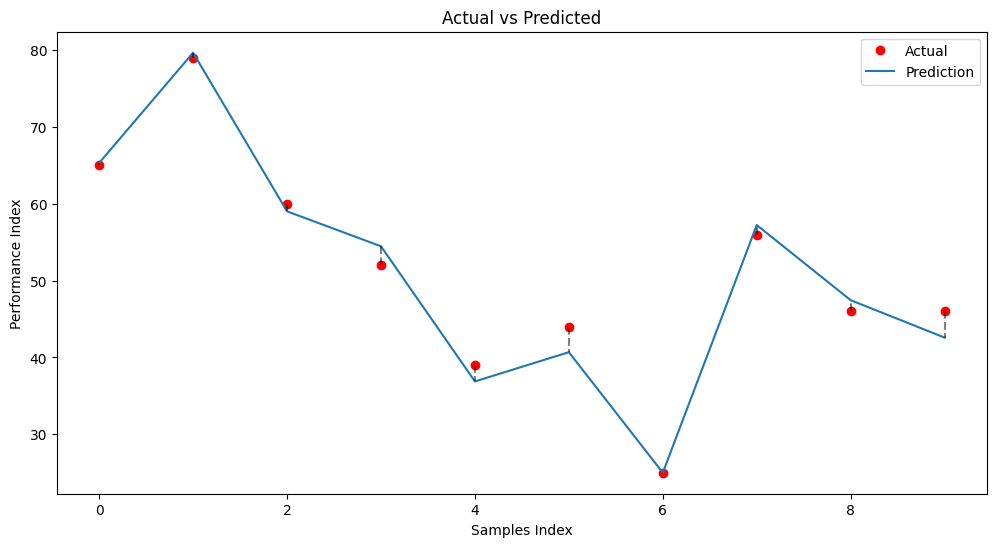

In [317]:
# Take first 10 samples to draw
plt.figure(figsize=(12, 6))
plt.plot(y_test_2c_v3.values[:10],'ro',label='Actual')

# using line to show the predicted values
plt.plot(y_pred_2c_v3[:10], label='Prediction')

# Draw a line to connect the actual and predicted values
for i in range(10):
    plt.plot([i, i], [y_test_2c_v3.values[i], y_pred_2c_v3[i]], 'k--', alpha=0.5)

plt.xlabel('Samples Index')
plt.ylabel('Performance Index')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

#### 4. Linear Regression cho kết quả tốt nhất trên toàn tập dữ liệu ( Verson 2)

#### a. Xây dựng mô hình

In [318]:
# Thêm các đặc trưng mới (Studied Hours * Previous Scores) vào dữ liệu
# Tạo bản sao của dữ liệu huấn luyện và kiểm tra
X_train_2c_best = X_train.copy()
y_train_2c_best = y_train.copy()

X_test_2c_best = X_test.copy()
y_test_2c_best = y_test.copy()

# Thêm đặc trưng mới
X_train_2c_best['Hours Studied * Previous Scores'] = X_train_2c_best['Hours Studied'] * X_train_2c_best['Previous Scores']
X_test_2c_best['Hours Studied * Previous Scores'] = X_test_2c_best['Hours Studied'] * X_test_2c_best['Previous Scores']

X_test_2c_best['Previous scores * Previous Scores'] = X_test_2c_best['Previous Scores'] * X_test_2c_best['Previous Scores']
X_train_2c_best['Previous scores * Previous Scores'] = X_train_2c_best['Previous Scores'] * X_train_2c_best['Previous Scores']

# Step1. Tiền xử lý dữ liệu
X_train_2c_best = preprocess(X_train_2c_best)
X_test_2c_best = preprocess(X_test_2c_best)

# Step2. Huấn luyện mô hình
lr = OLSLinearRegression().fit(X_train_2c_best, y_train_2c_best)

# Step3. Dự đoán giá trị
w = lr.get_params()
w = np.round(w, 3)

# Step3. Dự đoán giá trị
y_pred_2c_best = lr.predict(X_test_2c_best)
y_pred_2c_best = np.round(y_pred_2c_best, 3)

# Đánh giá mô hình
mae = MAE(y_test_2c_best, y_pred_2c_best)
print("MAE (test_set): ", mae)
print("Weights: ", w)

MAE (test_set):  1.595279
Weights:  [-34.36    2.866   1.029   0.604   0.474   0.192  -0.     -0.   ]


#### b. Giá trị dự đoán

In [319]:
# show the predictions with best feature
X_Y_test_2c_best = np.hstack([X_test_2c_best, y_pred_2c_best.reshape(-1, 1)]) # combine X_test and y_pred
X_Y_test_2c_best = pd.DataFrame(X_Y_test_2c_best) # convert to DataFrame
X_Y_test_2c_best.drop(X_Y_test_2c_best.columns[0], axis=1, inplace=True) # drop the first column
X_Y_test_2c_best.columns = ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced','Studied Hours * Sample Practiced','Sample Practiced * Sample Practiced','Performance Index (Prediction)']
X_Y_test_2c_best.head() # show the first 5 predictions

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Studied Hours * Sample Practiced,Sample Practiced * Sample Practiced,Performance Index (Prediction)
0,7.0,74.0,0.0,8.0,1.0,518.0,5476.0,65.316
1,6.0,89.0,1.0,8.0,8.0,534.0,7921.0,79.655
2,3.0,79.0,0.0,8.0,1.0,237.0,6241.0,58.998
3,7.0,62.0,0.0,8.0,8.0,434.0,3844.0,54.451
4,5.0,51.0,0.0,7.0,7.0,255.0,2601.0,36.861


#### c. Trực quan hóa

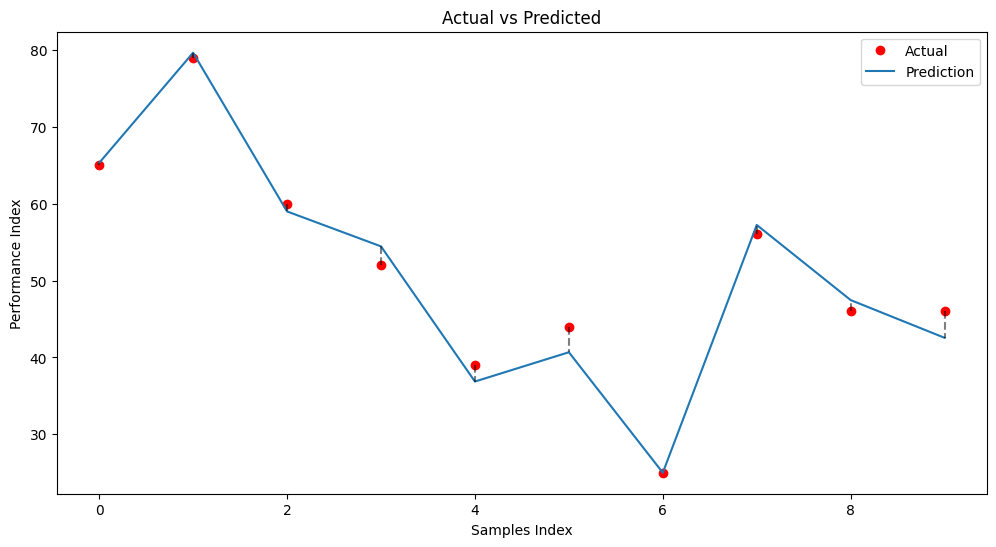

In [320]:
# Take first 10 samples to draw
plt.figure(figsize=(12, 6))
plt.plot(y_test_2c_best.values[:10],'ro',label='Actual')

# using line to show the predicted values
plt.plot(y_pred_2c_best[:10], label='Prediction')

# Draw a line to connect the actual and predicted values
for i in range(10):
    plt.plot([i, i], [y_test_2c_best.values[i], y_pred_2c_best[i]], 'k--', alpha=0.5)

plt.xlabel('Samples Index')
plt.ylabel('Performance Index')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

Công thức hồi quy (dựa trên mô hình tốt nhất mà sinh viên tự xây dựng/thiết kế), phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012

* Công thức hồi quy:

$$\text{Student Performance} = -34.036 + 2.866 * Hours Studied + 1.019 * Previous Scores + 0.604 * Extracurricular + 0.473 * Sleep Hours + 0.192 * Sample Question Papers Practiced + 0.0002 * (Hours Studied * Previous Scores) $$